# SN Global

This notebook is a detailed work through showing how the Signal-to-Noise is calulcated. The methods outlined below are by no means as the final method used, but are just to show working

This notebook contains:
* First analysis of SN on global level.
* Sample plots prooving the S/N method works.
* Plots useful for presentations outlining how the method works.


# Preamble

In [1]:
import utils
import sn_plotting
from warnings import filterwarnings
from utils import pprint_list
import open_ds
from classes import ExperimentTypes
import signal_to_noise
import xarray_class_accessors as xca
import constants
import sys
import matplotlib.pylab as pylab
import matplotlib
from dask.diagnostics import ProgressBar
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from importlib import reload
import xarray as xr
import numpy as np
import os
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# # Can be replaced
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

params = {'axes.labelsize': 'x-large',
          'legend.fontsize': 'x-large',
          'axes.titlesize': 'x-large',
          }

pylab.rcParams.update(params)

sys.path.append(constants.MODULE_DIR)
filterwarnings('ignore')

In [4]:
# The directory where all of the longrun mip data used in this notebook is stored.
variable = 'tas'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR,
                        variable, 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped'

In [5]:
IMG_DIR = constants.IMAGE_SAVE_DIR_TOP_LEVEL
notebook_number = '01'
model = 'CCSM3'

In [6]:
WINDOW = constants.WINDOWS_OF_INTEREST[1]
WINDOW

80

In [7]:
# Set-up logging for notebook
logger = utils.get_notebook_logger()
utils.change_logging_level('DEBUG')

# Control
THe SN for the piControl is get the stable/unstable bounds for each gridcell. This is to work out what can be considered natural variabilbity of the system.

In [9]:
pprint_list(os.listdir(ROOT_DIR), num_start_items=3)

lenght = 32
 0. tas_ann_HadGEM2_control_239_g025.nc
 1. tas_mon_HadCM3L_control_1000_g025.nc
 2. tas_mon_GFDLCM3_control_5200_g025.nc


In [10]:
models = constants.LONGRUNMIP_MODELS
model = 'ccsm3'

model_files = [f for f in os.listdir(ROOT_DIR) if (
    'control' in f or 'abrupt4x' in f) and model in f.lower()]
control_fname = str([f for f in model_files if 'control' in f][0])
abrupt_fname = str([f for f in model_files if 'abrupt' in f][0])
print(control_fname, abrupt_fname, sep=', ')

tas_mon_CCSM3_control_1530_g025.nc, tas_mon_CCSM3_abrupt4x_2120_g025.nc


In [11]:
control = xr.open_dataset(os.path.join(ROOT_DIR, control_fname), use_cftime=True).tas
abrupt = xr.open_dataset(os.path.join(ROOT_DIR,abrupt_fname), use_cftime=True).tas

- Creating converter from 7 to 5
- Creating converter from 5 to 7
- Creating converter from 7 to 5
- Creating converter from 5 to 7


In [16]:
# Anomalias
control_anom = control.clima.anomalies()

# Global Mean (space mean)
control_anom_smean = control_anom.clima.space_mean()
control_anom_smean

<xarray.DataArray 'tas' (time: 1518)>
array([-0.06736564, -0.00571943, -0.02881096, ...,  0.0296705 ,
        0.09553029, -0.01191925], dtype=float32)
Coordinates:
  * time     (time) object 0013-12-31 00:00:00 ... 1530-12-31 00:00:00

In [17]:
# Signal
control_anom_smean_signal = control_anom_smean.sn.calculate_rolling_signal(
    window=WINDOW, logginglevel='DEBUG')

- Calculting the rolling signal
- window=80, min_periods=80
data=
<xarray.DataArray 'tas' (time: 1518)>
array([-0.06736564, -0.00571943, -0.02881096, ...,  0.0296705 ,
        0.09553029, -0.01191925], dtype=float32)
Coordinates:
  * time     (time) object 0013-12-31 00:00:00 ... 1530-12-31 00:00:00
- Adjusting time points by 39


In [18]:
# Signal
control_anom_smean_signal = control_anom_smean.sn.calculate_rolling_signal(window=WINDOW,
                                                                           logginglevel='DEBUG')

# Lowess filter
control_anom_smean_loess = control_anom_smean.sn.apply_loess_filter()

# Noise
control_anom_smean_noise = control_anom_smean_loess.sn.calculate_rolling_noise(window=WINDOW,
                                                                               logginglevel='DEBUG')

# The signal to noise for the control anomlaies.
control_anom_smean_sn = control_anom_smean_signal/control_anom_smean_noise

lbound, ubound =\
    signal_to_noise.calculate_upper_and_lower_bounds(control_anom_smean_sn,
                                                     logginglevel='DEBUG')

- Calculting the rolling signal
- window=80, min_periods=80
data=
<xarray.DataArray 'tas' (time: 1518)>
array([-0.06736564, -0.00571943, -0.02881096, ...,  0.0296705 ,
        0.09553029, -0.01191925], dtype=float32)
Coordinates:
  * time     (time) object 0013-12-31 00:00:00 ... 1530-12-31 00:00:00
- Adjusting time points by 39
- Calculting the rolling noise
- Adjusting time points by 39
- Calculating Upper and lower control bounds
- np.nanpercentile used
- [-2.68981049]  - [2.01655842]


In [19]:
# Anomalis
abrupt_anom = abrupt.clima.anomalies(historical=control)

# Globab mean
abrupt_anom_smean = abrupt_anom.clima.space_mean()

# Signal
abrupt_anom_smean_signal = abrupt_anom_smean.sn.calculate_rolling_signal(
    window=WINDOW)

# Lowess
abrupt_anom_smean_loess = abrupt_anom_smean.sn.apply_loess_filter()

# Noise
abrupt_anom_smean_noise = abrupt_anom_smean_loess.sn.calculate_rolling_noise(
    window=WINDOW)

# Signal-to-Noise
abrupt_anom_smean_sn = abrupt_anom_smean_signal/abrupt_anom_smean_noise

# Merge with lower and upper bound
abrupt_anom_smean_sn = xr.merge([abrupt_anom_smean_sn.to_dataset(name='signal_to_noise'),
                                 lbound.to_dataset(name='lower_bound'),
                                 ubound.to_dataset(name='upper_bound')],
                                compat='override')
abrupt_anom_smean_sn

<xarray.Dataset>
Dimensions:          (time: 2042, window: 1)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 2042-12-31 00:00:00
  * window           (window) int64 80
Data variables:
    signal_to_noise  (window, time) float64 nan 14.46 14.52 ... -1.593 -1.532
    lower_bound      (window) float64 -2.69
    upper_bound      (window) float64 2.017

In [20]:
unstable_sn_da = abrupt_anom_smean_sn.utils.above_or_below(
    'signal_to_noise', greater_than_var = 'upper_bound', less_than_var = 'lower_bound')

stable_sn_da = abrupt_anom_smean_sn.utils.between(
    'signal_to_noise', less_than_var = 'upper_bound', greater_than_var = 'lower_bound')

In [21]:
abtupt_unstable = abrupt_anom_smean.where(np.isfinite(unstable_sn_da))
abrupt_stable = abrupt_anom_smean.where(np.isfinite(stable_sn_da))

In [22]:
# Manual Calculation for Demonstations

# Sample period is the years that we want to look at
sample_period = (0,WINDOW) #(1200,1261), 61

# The length of the sample_period varible
window_length = WINDOW

# Subset
sample_data = abrupt_anom_smean.isel(time=slice(*sample_period))

# Gradient and y-intercept of the sample data (use=[0,1] will return grad and y intercept)
gradient_sp, yintercept_sp = xca.SignalToNoise.trend_line(sample_data.values, use=[0,1])
print(f'{gradient_sp=}, {yintercept_sp=}')

# Trend line (fitted_line) for the sample data to demonstrate method is working.
x_values = np.arange(len(sample_data.time.values))
fitted_line = gradient_sp * x_values + yintercept_sp

# Loess filtered 4xabrupt anomalies space mean. 
yhat = xca.SignalToNoise.loess_filter(abrupt_anom_smean.values)

# Calculating the signal for the sample point
signal_sp = gradient_sp * window_length
print(f'{signal_sp=}')

gradient_sp=0.014239763098594689, yintercept_sp=2.8623722785049006
signal_sp=1.139181047887575


# Plots

## Control

In [23]:
control_anom_smean

<xarray.DataArray 'tas' (time: 1518)>
array([-0.06736564, -0.00571943, -0.02881096, ...,  0.0296705 ,
        0.09553029, -0.01191925], dtype=float32)
Coordinates:
  * time     (time) object 0013-12-31 00:00:00 ... 1530-12-31 00:00:00

TypeError: float() argument must be a string or a number, not 'cftime._cftime.DatetimeGregorian'

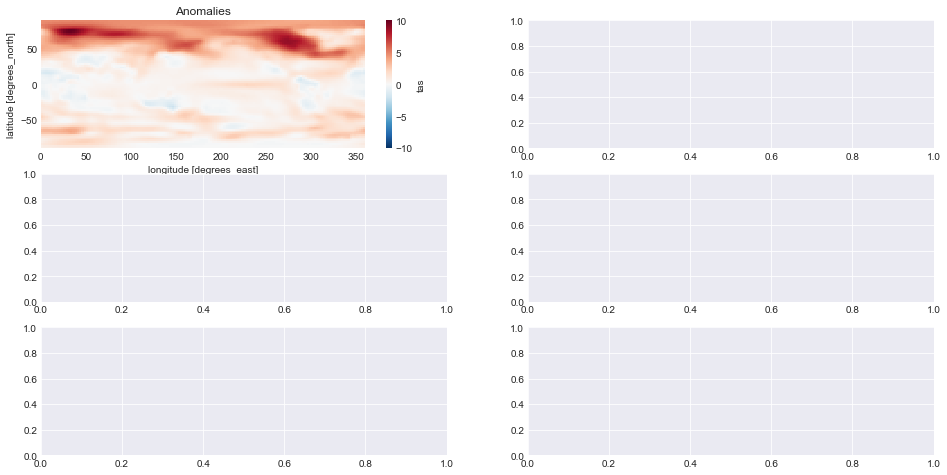

In [24]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3,ncols=2, figsize=(16,8))
control_anom.isel(time=0).plot(ax=ax1)
ax1.set_title('Anomalies')
control_anom_smean.plot(ax=ax2)
ax2.set_title('Global Mean')
control_anom_smean_signal.plot(ax=ax3)
ax3.set_title('Siganl')
control_anom_smean_loess.plot(ax=ax4)
ax4.set_title('Lowess Filtered')
control_anom_smean_noise.plot(ax=ax5)
ax5.set_title('Noise')
control_anom_smean_sn.plot(ax=ax6)
ax6.set_title('Signal-to-Noise')

fig.suptitle('Control')

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = plt.gca()
control_anom_smean_sn.plot(label='Signal/Noise', ax=ax, color='green', alpha=0.8)
control_anom_smean.plot(label='GMST', ax=ax, color='blue', alpha=0.8)

time = control_anom_smean.time.values

ax.plot(time, [lbound.values] * len(control_anom_smean.time.values), 
        label='1st and 99th Percentile\nof Signal/Noise',
       c='green', linestyle =':', alpha=0.4)

ax.plot(time, [ubound.values] * len(control_anom_smean.time.values),
       c='green', linestyle =':', alpha=0.4)

ax.set_xlim(time[0], time[-1])
ax.legend(ncol=4, fontsize=16, loc='upper right')
ax.set_ylabel(r'GMST Anomaly ($^{\circ}C$) and S/N', size=16);
ax.set_xlabel('Time (years)')
# ax.tick_params(axis='x', labelsize=14)
# ax.tick_params(axis='y', labelsize=14)
ax.set_title(f'Pre-Industrial Control GMST Anomalies and S/N ({model})', size=18)

fig.savefig(f'{IMG_DIR}/{notebook_number}_piControl_SN.png', dpi=200)

## Abrupt4x

In [ ]:
sample_period_2 = (0, 200000)

In [ ]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3,ncols=2, figsize=(16,14))
abrupt_anom_smean.plot(ax=ax1)
ax1.set_title('Global Mean')
ax2.plot(yhat)
ax2.set_title('Lowess Trend')
abrupt_anom_smean_loess.plot(ax=ax3)
ax3.set_title('Lowess Detrend')
abrupt_anom_smean_noise.plot(ax=ax4)
ax4.set_title('Noise')
abrupt_anom_smean_signal.plot(ax=ax5)
ax5.set_title('Siganl')
abrupt_anom_smean_sn.signal_to_noise.plot(ax=ax6)
ax6.set_title('Signal-to-Noise')

In [ ]:
# A nice plot of the space mean
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
abrupt_anom_smean.plot(ax = ax, color='green', alpha = 0.8)
ax.set_xlim(abrupt_anom_smean.time.values[0], abrupt_anom_smean.time.values[-1])
ax.set_xlabel('Time', size=14)
ax.set_ylabel('GMST', size=14)
# fig.savefig(f'{IMG_DIR}/{notebook_number}_GMST.png', dpi=200)

In [ ]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
sample_data.plot(ax = ax, color='green', alpha = 0.8, marker='o', label='GMST')
ax.plot(sample_data.time.values, fitted_line,
        label=f'Linear Trend Line\nGrad = {gradient_sp:.2f}\nSignal {signal_sp:.2f}')
ax.set_xlim(sample_data.time.values[0], sample_data.time.values[-1])
ax.set_xlabel('Time (years)', size=14)
ax.set_ylabel(r'GMST Anomaly ($^{\circ}C$)', size=14)
# ax.legend(ncol=2);


c_gmst = plt.gca().lines[0].get_color()
ax.annotate('GMST', xy = (0.35, 0.7), xycoords='axes fraction', size=12, c=c_gmst, alpha=0.8,
            xytext = (0.25, 0.8),
           arrowprops=dict(facecolor=c_gmst, shrink=0.05, alpha=0.8))


c_line = plt.gca().lines[1].get_color()
text = f'Linear Trend Line\nGrad   = {gradient_sp:.2f} (degC/year)\nSignal = {gradient_sp:.2f} * {window_length} (degC)\n           = {signal_sp:.2f} (degC)'
ax.annotate(text,
            xy = (0.37, 0.51), xycoords='axes fraction', size=14, c=c_line, alpha=0.8,
            xytext = (0.45, 0.2),
           arrowprops=dict(facecolor=c_line, shrink=0.05, alpha=0.8))

ax.set_title(f'Abrupt 4xCO2 GMST Anomalies ({model})', size=18);


fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_GMST_Signal.png', dpi=200)

In [ ]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,1,1)
abrupt_anom_smean.isel(time=slice(*sample_period)).plot(ax=ax1, label='Original', color='green', marker='o'
                                                       ,alpha=0.8)
ax1.plot(sample_data.time.values[sample_period[0]:sample_period[-1]],
         yhat[sample_period[0]:sample_period[-1]], label='LOWESS', color='blue',alpha=0.8)
# ax1.set_ylim([2.4,4])
ax1.set_title('Original', fontsize=16)
ax1.set_xlabel('')
ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax1.set_ylabel(r'GMST Anomaly ($^{\circ}C$)')
ax1.legend()

ax2 = fig.add_subplot(2,1,2)
abrupt_anom_smean_loess.isel(time=slice(*sample_period)).plot(ax=ax2, color='green', marker='o',alpha=0.8)
ax2.set_ylim([-0.6, 1])
ax2.set_title('LOWESS Detrended', fontsize=16)
ax2.set_xlabel('Time (years)') #, fontsize=14)
ax2.set_ylabel(r'GMST Anomaly ($^{\circ}C$)')#, size=14)

ax1.set_xlim(sample_data.time.values[0], sample_data.time.values[-1]);
ax2.set_xlim(sample_data.time.values[0], sample_data.time.values[-1]);

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_GMST_lowess.png', dpi=200)

In [ ]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(211)
abrupt_anom_smean_signal.isel(time=slice(*sample_period_2)).plot(ax=ax, color='green', label='Signal')
abrupt_anom_smean_noise.isel(time=slice(*sample_period_2)).plot(ax = ax, color='blue', label='Noise')
ax.set_title('Signal and Noise')
ax.set_ylabel(r'$^{\circ}C$')
ax.set_xlabel('')
ax.legend()

ax2 = fig.add_subplot(212)
abrupt_anom_smean_sn.signal_to_noise.isel(time=slice(*sample_period_2)).plot(ax = ax2, color='darkred')
ax2.set_title('Signal to Noise')
ax2.set_ylabel('Signal to Noise')

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_GMST_Signal_Npng', dpi=200)

In [ ]:
bounds = {'lower': float(lbound.values), 'upper':float(ubound.values)}
bounds

In [ ]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn.signal_to_noise.squeeze(), abrupt_anom_smean,
                      temp_highlight = abrupt_stable.signal_to_noise, 
                      sn_highlight = stable_sn_da.signal_to_noise.squeeze(), 
                              bounds = bounds)

ax.set_xlim(abrupt_anom_smean_sn.time.values[0], abrupt_anom_smean_sn.time.values[505])
ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=18);

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_global_sn_temp_anomaly_t500.png',
            bbox_inches='tight', dpi=200)

In [ ]:
bounds

In [ ]:
constants.LONGRUNMIP_LENGTH

In [ ]:
reload(sn_plotting)

In [ ]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn.signal_to_noise.squeeze(), abrupt_anom_smean,
                      temp_highlight = abrupt_stable.signal_to_noise, 
                      sn_highlight = stable_sn_da.signal_to_noise.squeeze(), 
                              bounds = bounds)

ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=18);
ax.set_xlim(abrupt_anom_smean_sn.time.values[0], abrupt_anom_smean_sn.time.values[constants.LONGRUNMIP_LENGTH])

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_global_sn_temp_anomaly_tmax.png',
            bbox_inches='tight', dpi=200)